# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader
%autoreload 1

In [4]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()

In [5]:
def read_pair(leg1, leg2, data_source, initial_date, final_date, close_type='Adj Close'):
    
    leg1_df = data.DataReader(leg1, data_source, initial_date, final_date)
    leg2_df = data.DataReader(leg2, data_source, initial_date, final_date)
    
    # filter columns of interest
    leg1_name = leg1 + "_close"
    leg2_name = leg2 + "_close"
    leg1_df = leg1_df[[close_type]].rename(columns={close_type: leg1_name})
    leg2_df = leg2_df[[close_type]].rename(columns={close_type: leg2_name})
    
    # concat in df
    pair_df = pd.concat([leg1_df, leg2_df], axis=1)
    
    # plot
    pair_df.plot(figsize=(20, 10), use_index=True, grid=True);
    
    return pair_df

# 3. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [6]:
etfs = pd.read_excel('data/etfs/commodity_ETFs.xlsx')

In [7]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


Remove duplicates

In [8]:
etfs_unique = etfs[~etfs.duplicated(subset=['Ticker'], keep='first')].sort_values(['Ticker'])

In [9]:
tickers = etfs_unique.Ticker.unique()

In [10]:
initial_date = '01-01-2015'
final_date = '01-01-2016'
data_source = 'yahoo'
error_counter = 0
dataset = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        df = df[['Adj Close']].rename(columns={'Adj Close':ticker}) # filter close price only
        dataset[ticker] = df.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for AMJL
Not Possible to retrieve information for AOIL
Not Possible to retrieve information for BAR
Not Possible to retrieve information for BATT
Not Possible to retrieve information for BCD
Not Possible to retrieve information for BCI
Not Possible to retrieve information for BMLP
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for COMB
Not Possible to retrieve information for COMG
Not Possible to retrieve information for DWT
Not Possible to retrieve information for FTXN
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for GLDW
Not Possible to retrieve information for GOAU
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for JHME
Not Possible to retrieve information for MLPE
Not Possible to retrieve information for MLPO
Not Possible to retrieve information for MLPQ
Not Possible to retrieve information f

In [11]:
print('Unable to download ' + str(error_counter/len(tickers)*100) + '% of the ETFs')
print('From now on, we are only considering ' + str(len(tickers)-error_counter) + ' ETFs')

Unable to download 17.51152073732719% of the ETFs
From now on, we are only considering 179 ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [12]:
first_count = True
for k in dataset.keys():
    if dataset[k] is not None:
        if first_count:
            etfs_pricing = dataset[k]
            first_count = False
        else:
            etfs_pricing = pd.concat([etfs_pricing, dataset[k]], axis=1)
            
print(etfs_pricing.shape)

(252, 179)


**Remove ETFs without sufficient information**

In [13]:
null_values = etfs_pricing.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AMUB    235
CRAK    159
DRIP    103
GASX    232
GDXS     29
GDXX     29
GUSH    101
MLPB    198
PLTM      8
SGDJ     60
TPYP    151
UCIB    194
dtype: int64

In [14]:
threshold = 0
to_remove = list(null_values[null_values>threshold].index)
etfs_pricing = etfs_pricing.drop(columns=to_remove)
print(etfs_pricing.shape)

(252, 167)


In [15]:
etfs_returns = etfs_pricing.pct_change()
etfs_returns = etfs_returns.iloc[1:]
etfs_returns.head()

,AGF,AGQ,AMJ,AMLP,AMU,AMZA,ATMP,BAL,BCM,BDD,...,VDE,WEAT,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.005216,0.053097,-0.045397,-0.027180,-0.045270,-0.055013,-0.040658,0.020463,-0.012195,-0.026667,...,-0.039668,0.008772,-0.048523,-0.041368,-0.036929,-0.064116,-0.025797,-0.032382,-0.031305,-0.047797
2015-01-06,0.018532,0.040534,-0.020094,-0.013388,-0.017339,-0.028118,-0.016145,-0.008456,0.000317,-0.015069,...,-0.015037,0.006324,-0.031412,-0.014691,-0.013791,-0.030276,-0.013481,-0.007968,-0.016611,-0.040389
2015-01-07,0.010189,0.000713,0.000911,-0.003540,-0.002161,-0.011116,-0.008547,0.004386,-0.006329,-0.022253,...,0.002450,-0.019639,-0.009920,0.002130,0.004434,-0.010027,-0.005369,-0.009638,-0.005835,-0.000650
2015-01-08,0.000000,-0.028246,0.012975,0.008881,0.011909,0.013643,0.012759,0.002183,0.001274,0.021337,...,0.021623,-0.020032,0.016571,0.022450,0.009508,0.033840,0.009813,0.022709,0.016991,0.027334
2015-01-09,-0.001441,0.017587,-0.002921,0.000587,-0.000357,0.002559,0.001021,0.000726,0.000000,0.001393,...,-0.006993,-0.007359,-0.014026,-0.007925,-0.002355,0.007794,0.001458,0.000000,0.002126,-0.016561


In [16]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  13861.0


**Applying PCA on Returns**

In [17]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(etfs_returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
pca.components_.T.shape

(167, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. 

In [19]:
X = preprocessing.StandardScaler().fit_transform(pca.components_.T)
print(X.shape)

(167, 50)


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [20]:
clf = DBSCAN(eps=2, min_samples=2)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

Clusters discovered: 16


In [21]:
clustered_series = pd.Series(index=etfs_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [22]:
counts = clustered_series.value_counts()
print("Clusters formed: %d" % len(counts))
print("Pairs to evaluate: %d" % (counts*(counts-1)/2).sum())

Clusters formed: 16
Pairs to evaluate: 177


In [23]:
print(counts)

1     13
4     10
8      7
0      5
12     4
11     3
6      3
5      3
15     2
14     2
13     2
10     2
9      2
7      2
3      2
2      2
dtype: int64


**Fundamental analysis for clusters**

In [24]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))
    #print('\nCluster {}:\n{}'.format(label_n,etfs_cluster_n.Segment.value_counts()))


Cluster 0:
    Ticker            Segment
156    AMJ  Equity: U.S. MLPs
170    AMU  Equity: U.S. MLPs
167   ATMP  Equity: U.S. MLPs
161   MLPA  Equity: U.S. MLPs
159   MLPI  Equity: U.S. MLPs

Cluster 1:
    Ticker                    Segment
72     BCM  Commodities: Broad Market
0      DBA   Commodities: Agriculture
28     DBC  Commodities: Broad Market
78    DJCI  Commodities: Broad Market
32     DJP  Commodities: Broad Market
50    FTGC  Commodities: Broad Market
53     GCC  Commodities: Broad Market
148    GSC  Commodities: Broad Market
30     GSG  Commodities: Broad Market
79     GSP  Commodities: Broad Market
20     RJA   Commodities: Agriculture
145    RJI  Commodities: Broad Market
37    USCI  Commodities: Broad Market

Cluster 2:
    Ticker               Segment
378    CGW  Equity: Global Water
380    PIO  Equity: Global Water

Cluster 3:
  Ticker                          Segment
2   CORN    Commodities: Agriculture Corn
7    JJG  Commodities: Agriculture Grains

Cluster 4:
   

Comparing results obtaned with most obvious scenario:

In [25]:
grouped = etfs_unique.groupby(by='Segment').count()[['Ticker']]
grouped[grouped.Ticker > 1]

,Ticker
Segment,
Commodities: Agriculture,7
Commodities: Agriculture Grains,3
Commodities: Agriculture Sugar,2
Commodities: Broad Market,21
Commodities: Energy,4
Commodities: Energy Crude Oil,10
Commodities: Energy Natural Gas,3
Commodities: Industrial Metals,2
Commodities: Industrial Metals Copper,2


What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

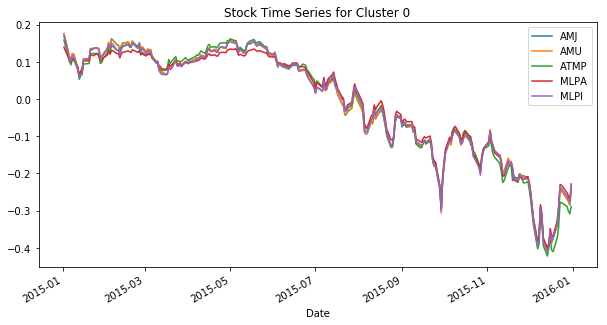

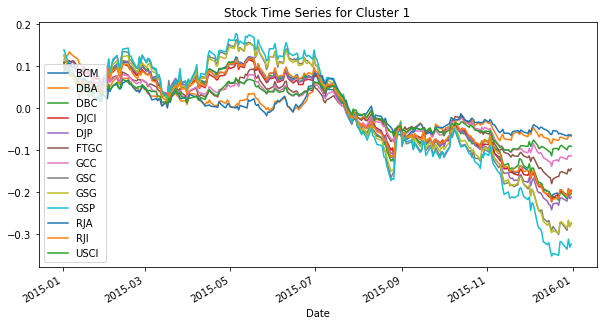

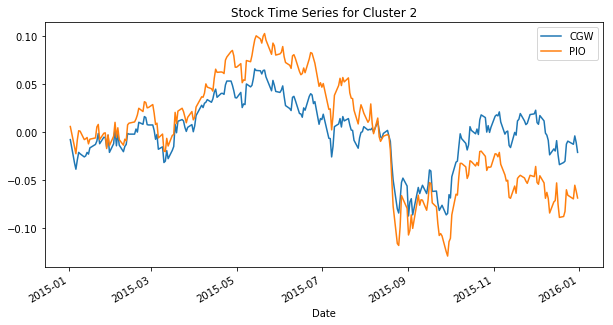

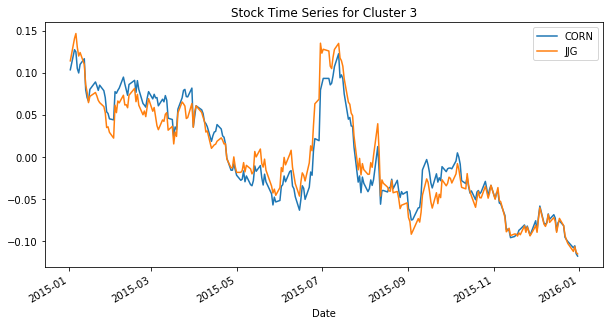

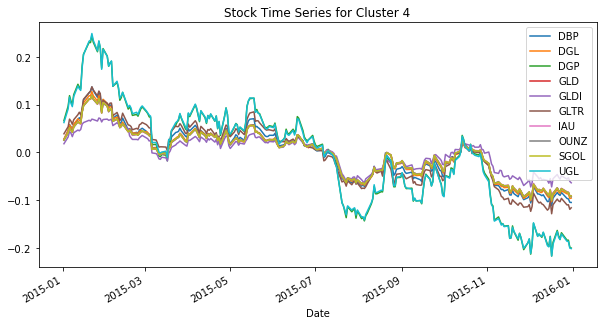

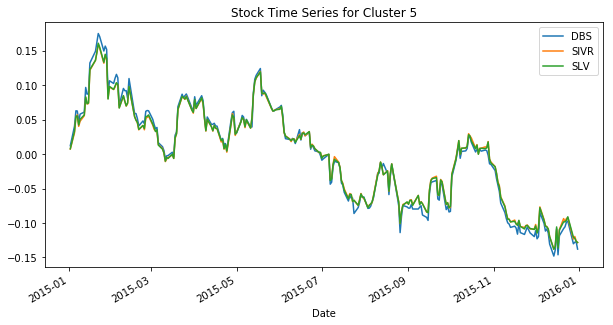

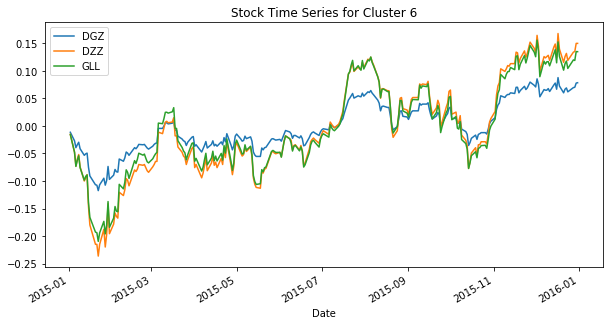

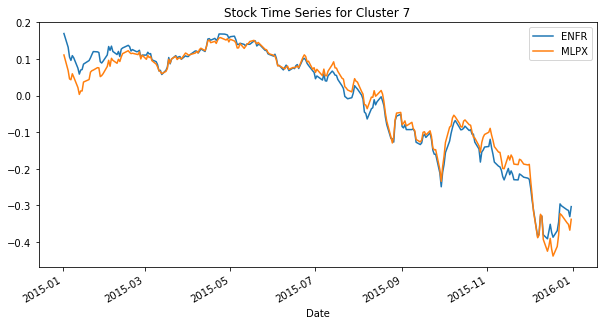

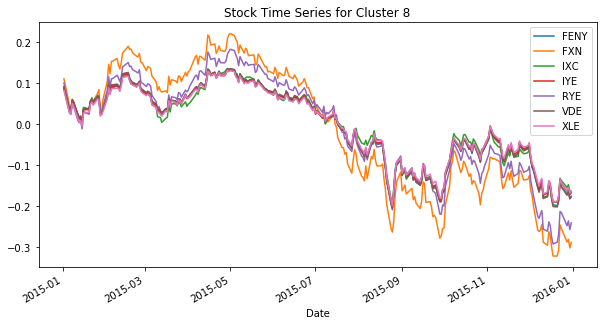

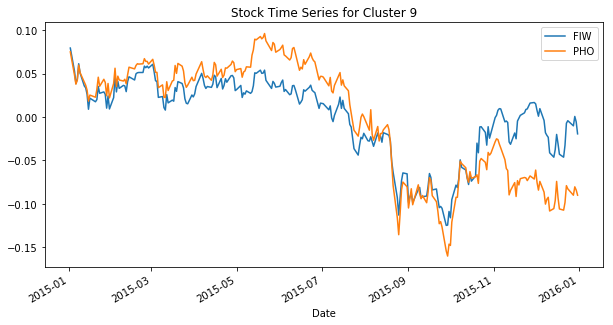

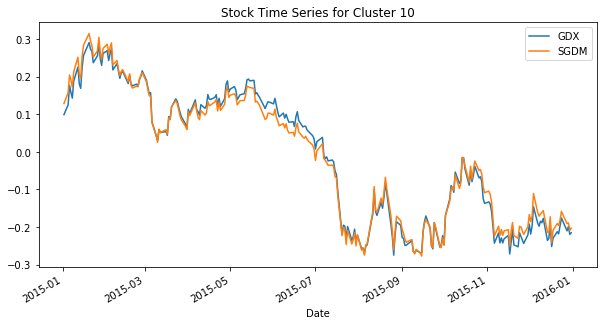

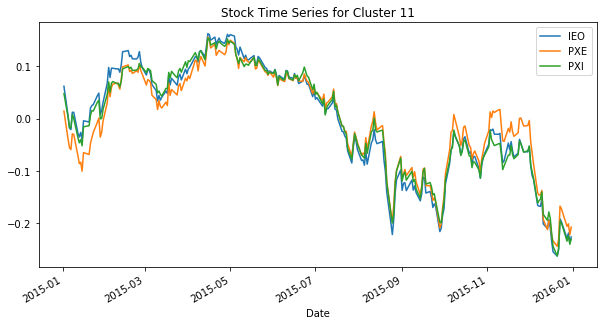

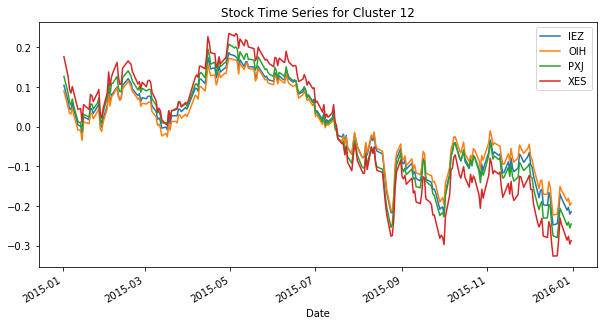

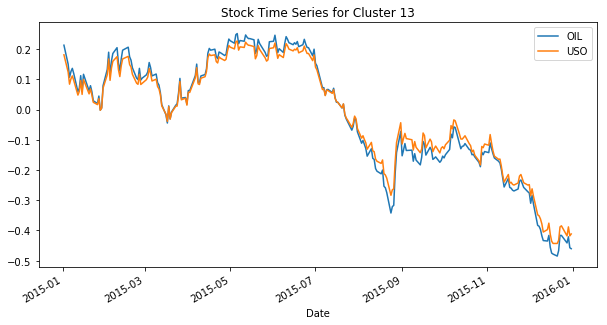

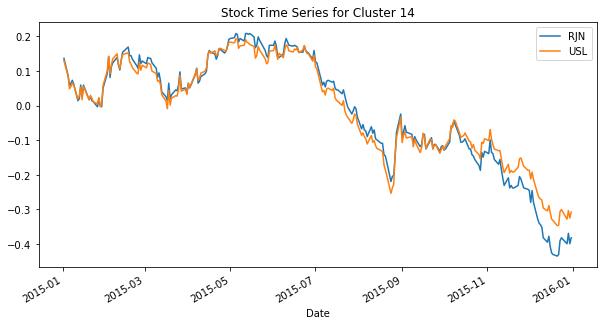

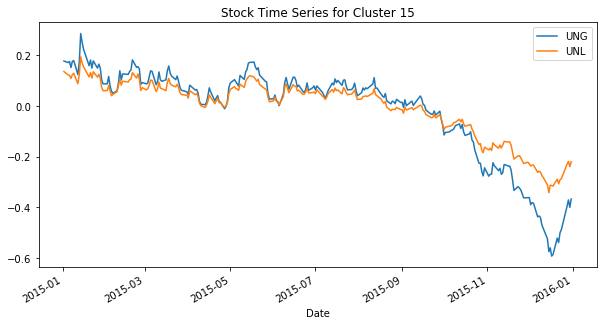

In [26]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [27]:
total_pairs = []
threshold = 0.05
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold, 5)
    total_pairs.extend(pairs)
    #print('\nCluster {}: {}'.format(clust,[(pair[0], pair[1], pair[2]['p_value']) for pair in pairs]))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))

Found 55 pairs


In [28]:
print('The pairs contain {} unique tickers'.format(
        len(np.unique([(element[0], element[1]) for element in total_pairs]))))

The pairs contain 38 unique tickers


**Applying Bollinger Bands**

In [29]:
lookback_multiplier=2
sharpe_results_bollinger = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    #print('Cointegration coefficient: ',coint_result['coint_coef'])
    hl = series_analyzer.calculate_half_life(coint_result['spread'])
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'], 
                                                               lookback_multiplier*int(round(hl)))
    sharpe_results_bollinger.append(sharpe)



AMJ,ATMP
APR 0.08828572313632876
Sharpe 2.475357228033839


AMU,ATMP
APR 0.09525651250748224
Sharpe 2.4747169670444076


BCM,FTGC
APR 0.033781133237523076
Sharpe 1.050681882129336


BCM,GSC
APR 0.0230107690228456
Sharpe 0.678770836247851


BCM,USCI
APR 0.00026228856484067364
Sharpe 0.03344645945563307


DBA,DJCI
APR 0.06976715116699128
Sharpe 1.5450117096535092


DBA,DJP
APR 0.09467984798187734
Sharpe 2.080876895772274


DBA,RJA
APR 0.042450308764941935
Sharpe 1.7707383968484645


DBC,DJCI
APR 0.023314508496127484
Sharpe 0.594604418672503


DBC,DJP
APR -0.018784065824452023
Sharpe -0.994377081251679


DBC,FTGC
APR -0.05286496516712069
Sharpe -1.8257604639162235


DBC,USCI
APR 0.08579092390620202
Sharpe 2.1024829399430907


DJCI,FTGC
APR -0.0003885319543036614
Sharpe 0.007699655776989449


DJCI,GCC
APR 0.0974765260603816
Sharpe 3.5342293114777976


DJCI,USCI
APR 0.04605237265466311
Sharpe 1.2496304880442828


DJP,FTGC
APR 0.03108768431944342
Sharpe 1.453980022224619


DJP,USCI
APR 0.0

**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.563803967705211


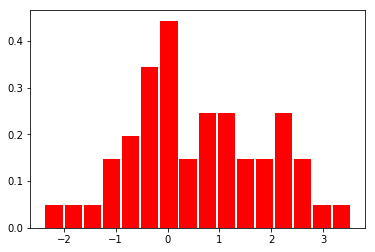

In [30]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

**Applying the Kalman filter based strategy**

In [31]:
sharpe_results_kalman = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, sharpe = trader.kalman_filter(y=coint_result['Y'], x=coint_result['X'])
    sharpe_results_kalman.append(sharpe)



AMJ,ATMP
APR 0.11796696537941331
Sharpe 2.1828696429332752


AMU,ATMP
APR 0.1001438114827522
Sharpe 1.886499340807082


BCM,FTGC
APR 0.02559544134629821
Sharpe 1.871397923522095


BCM,GSC
APR 0.11019562877193012
Sharpe 2.3064826406552625


BCM,USCI
APR 0.04723754203783992
Sharpe 1.8756763042202977


DBA,DJCI
APR 0.024455022331985266
Sharpe 0.6611283869195889


DBA,DJP
APR -0.005274842852738049
Sharpe -0.1485800211359606


DBA,RJA
APR -0.015891573571015116
Sharpe -0.8127248320483722


DBC,DJCI
APR 0.016188846768688814
Sharpe 0.753431824087145


DBC,DJP
APR -0.0057482597171384375
Sharpe -0.6905490134998454


DBC,FTGC
APR 0.06698800139455252
Sharpe 2.0777886264255585


DBC,USCI
APR 0.09295746204760547
Sharpe 1.8801423336758873


DJCI,FTGC
APR 0.03232452826089771
Sharpe 1.6533869679917474


DJCI,GCC
APR 0.027127959543223668
Sharpe 1.3140403299063281


DJCI,USCI
APR 0.08179931309636834
Sharpe 2.1548479525817723


DJP,FTGC
APR 0.004906034339082099
Sharpe 0.6177188038035533


DJP,USCI
APR 0

**Kalman Filter Performance**

Sharpe Ratio Results: 
Average result:  0.5762270467642083


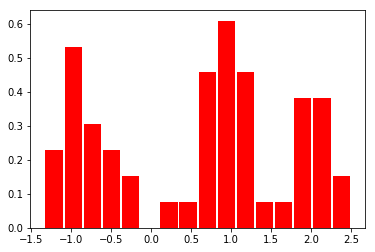

In [32]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))